<a href="https://colab.research.google.com/github/shu-bee/Pytorch_tutorial/blob/main/Training_a_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ロードと正規化

In [ ]:
import torch 
import torchvision 
import torchvision.transforms as transforms

Dataset&Dataloader

https://konchangakita.hatenablog.com/entry/2020/05/21/220000

In [ ]:
transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                        download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,
                                       shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,
                                        download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,
                                       shuffle=False,num_workers=2)

classes=('plane','car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


使用するデータの可視化

12500
4



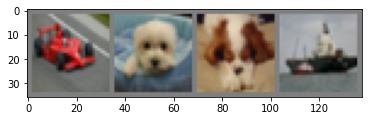

   car    dog    dog   ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img /2+0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

#get some random training images
dataiter = iter(trainloader)
print(len(dataiter))
images, labels = dataiter.next()

print(len(images))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%6s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

損失関数とオプティマイザーを定義

目的関数にクロスエントロピーを用いる効果について

https://qiita.com/kenta1984/items/59a9ef1788e6934fd962#:~:text=p%E3%81%AF%E7%9C%9F%E3%81%AE%E7%A2%BA%E7%8E%87,%E8%AA%A4%E5%B7%AE%E3%81%AF%E5%A4%A7%E3%81%8D%E3%81%8F%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82





In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer= optim.SGD(net.parameters(), lr=0.001,momentum=0.9)

ネットワークをトレーニング

In [ ]:
for epoch in range(2):
  running_loss =0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels=data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs=net(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss += loss.item()
    if i%2000==1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch+1,i+1,running_loss/2000))
      running_loss = 0.0

print('Finished Training')



[1,  2000] loss: 2.248
[1,  4000] loss: 1.917
[1,  6000] loss: 1.710
[1,  8000] loss: 1.589
[1, 10000] loss: 1.514
[1, 12000] loss: 1.459
[2,  2000] loss: 1.407
[2,  4000] loss: 1.385
[2,  6000] loss: 1.376
[2,  8000] loss: 1.310
[2, 10000] loss: 1.309
[2, 12000] loss: 1.280
Finished Training


In [ ]:
c = list(0. for i in range(10))#リスト内包表記
print(c)
print(type(c[0]))

c=[]
for i in range(10):
  c.append(0.0)
print(c)
print(type(c[0]))

c = [0.0]*10
print(c)
print(type(c[0]))


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'float'>
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'float'>
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'float'>


ネットワークをテスト

with torch.no_grad()を使う理由

https://qiita.com/a_yoshii/items/598365cf3b68955e11c5#comments

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():#パラメータを保存しないことによるメモリ不足の対策（大きなデータでは必要）
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 70 %
Accuracy of  bird : 39 %
Accuracy of   cat : 50 %
Accuracy of  deer : 42 %
Accuracy of   dog : 37 %
Accuracy of  frog : 52 %
Accuracy of horse : 70 %
Accuracy of  ship : 72 %
Accuracy of truck : 53 %


GPUでのトレーニング

テンソルをGPUに転送するのと同じように、ニューラルネットをGPUに転送します。
CUDAが利用可能な場合、最初にデバイスを最初に表示されるcudaデバイスとして定義しましょう。

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)